### MNIST Model and Misclassified Images

In [1]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
import alibi
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time
from alibi.explainers import CounterFactualProto
print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

TF version:  2.4.1
Eager execution enabled:  False


In [2]:
x_train = np.load('quickdraw_x_train.npy')
y_train = np.load('quickdraw_y_train.npy')
x_test = np.load('quickdraw_x_test.npy')
y_test = np.load('quickdraw_y_test.npy')

### Evaluate MC-Model on Test Set

In [3]:
cnn=load_model('cnn_quickdraw_5_classes.h5')

### Loading the Generated Explanations

In [4]:
quickdraw_min_edit_cf = np.load('quickdraw_min_edit_cf.npy')
quickdraw_cem_cf = np.load('quickdraw_cem_cf.npy')
quickdraw_vlk_cf = np.load('quickdraw_vlk_cf.npy')

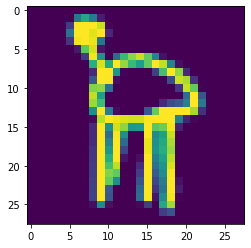

In [5]:
plt.imshow(quickdraw_min_edit_cf[4])

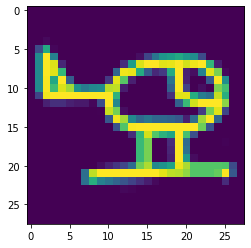

In [6]:
plt.imshow(quickdraw_cem_cf[13])

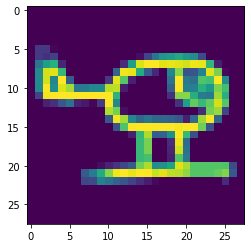

In [7]:
plt.imshow(quickdraw_vlk_cf[13])

In [8]:
user_0 = np.load('../../../../../../eoind/cfe_quickdraw_0.npy')
user_1 = np.load('../../../../../../eoind/cfe_quickdraw_1.npy')
user_2 = np.load('../../../../../../eoind/cfe_quickdraw_2.npy')
user_3 = np.load('../../../../../../eoind/cfe_quickdraw_3.npy')
user_4 = np.load('../../../../../../eoind/cfe_quickdraw_4.npy')

In [9]:
user_counterfactual_dataset = []

for user in [user_0, user_1, user_2, user_3, user_4]:
    
    user_counterfactual_dataset.append(user)
    
user_counterfactual_dataset = np.array(user_counterfactual_dataset)

In [10]:
user_counterfactual_dataset.shape

(5, 30, 28, 28, 1)

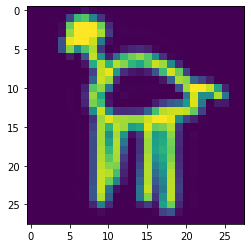

In [11]:
plt.imshow(user_4[4])

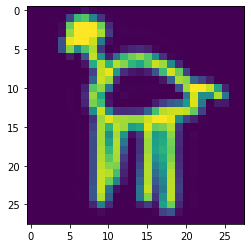

In [12]:
plt.imshow(user_counterfactual_dataset[4][4])

In [13]:
user_counterfactual_dataset = np.load('user_explanations_quickdraw.npy')

In [14]:
misclassification_indices_test_set = np.load('quickdraw_misclassification_indices_test_set.npy')

### Visualizing Human Explanations

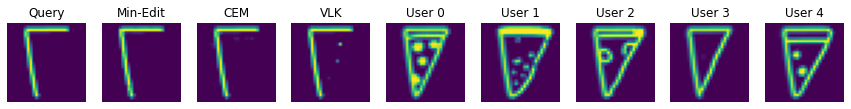

In [15]:
for image in [6]:

    image_index = image

    f, axarr = plt.subplots(nrows=1,ncols=9, figsize=(15,15))
    plt.sca(axarr[0]); 
    plt.imshow(x_test[misclassification_indices_test_set[image_index]], cmap='viridis'); plt.title('Query')
    plt.axis('off')

    
    plt.sca(axarr[1]); 
    plt.imshow(quickdraw_min_edit_cf[image_index],cmap='viridis'); plt.title('Min-Edit')
    plt.axis('off')

    plt.sca(axarr[2]); 
    plt.imshow(quickdraw_cem_cf[image_index],cmap='viridis'); plt.title('CEM')
    plt.axis('off')
    
    plt.sca(axarr[3]); 
    plt.imshow(quickdraw_vlk_cf[image_index],cmap='viridis'); plt.title('VLK')
    plt.axis('off')
    
    plt.sca(axarr[4]); 
    plt.imshow(user_0[image_index], cmap='viridis'); plt.title('User 0')
    plt.axis('off')

    plt.sca(axarr[5]); 
    plt.imshow(user_1[image_index], cmap='viridis'); plt.title('User 1');
    plt.axis('off')

    plt.sca(axarr[6]); 
    plt.imshow(user_2[image_index], cmap='viridis'); plt.title('User 2');
    plt.axis('off')


    plt.sca(axarr[7]); 
    plt.imshow(user_3[image_index], cmap='viridis'); plt.title('User 3');
    plt.axis('off')

    plt.sca(axarr[8]); 
    plt.imshow(user_4[image_index], cmap='viridis'); plt.title('User 4');
    plt.axis('off')


    plt.show()

### Comparisons - Proximity 

#### Distance between Query and CFE

In [16]:
import scipy

In [17]:
min_edit_l1 = []
cem_l1 = []
vlk_l1 = []

min_edit_l2 = []
cem_l2 = []
vlk_l2 = []

for image in range(30):
    
    query = x_test[misclassification_indices_test_set[image]].flatten()
    min_edit = quickdraw_min_edit_cf[image].flatten()
    cem = quickdraw_cem_cf[image].flatten()
    vlk = quickdraw_vlk_cf[image].flatten()
    
    min_edit_l1.append(scipy.spatial.distance.cityblock(query,min_edit))
    cem_l1.append(scipy.spatial.distance.cityblock(query,cem))
    vlk_l1.append(scipy.spatial.distance.cityblock(query,vlk))
    
    min_edit_l2.append(scipy.spatial.distance.euclidean(query,min_edit))
    cem_l2.append(scipy.spatial.distance.euclidean(query,cem))
    vlk_l2.append(scipy.spatial.distance.euclidean(query,vlk))
        

In [18]:
min_edit_l1 = np.array(min_edit_l1)
min_edit_l1_sem = scipy.stats.sem(min_edit_l1)

cem_l1 = np.array(cem_l1)
cem_l1_sem = scipy.stats.sem(cem_l1)

vlk_l1 = np.array(vlk_l1)
vlk_l1_sem = scipy.stats.sem(vlk_l1)



min_edit_l2 = np.array(min_edit_l2)
min_edit_l2_sem = scipy.stats.sem(min_edit_l2)

cem_l2 = np.array(cem_l2)
cem_l2_sem = scipy.stats.sem(cem_l2)

vlk_l2 = np.array(vlk_l2)
vlk_l2_sem = scipy.stats.sem(vlk_l2)


#### Human CFE Mean (We have several counterfactuals --- One for each user)

In [19]:
mean_l1 = []
mean_l2 = []

for instance in range(30):
    
    l1=[]
    
    l2 = []
    
    for user in [user_0, user_1, user_2, user_3, user_4]:
        l1.append(scipy.spatial.distance.cityblock(x_test[misclassification_indices_test_set[instance]].flatten(), user[instance].flatten()))
        l2.append(scipy.spatial.distance.euclidean(x_test[misclassification_indices_test_set[instance]].flatten(), user[instance].flatten()))
    mean_l1.append(np.mean(np.mean(l1)))
    mean_l2.append(np.mean(np.mean(l2)))

In [20]:
import scikit_posthocs as sp
from scipy.stats import stats

##### Manhattan

In [21]:
fvalue, pvalue = stats.f_oneway(np.array(min_edit_l1), np.array(cem_l1), np.array(vlk_l1),
                                np.array(mean_l1))
print(fvalue, pvalue)

107.02965388851811 2.8630247707542682e-33


In [22]:
sp.posthoc_conover([np.array(min_edit_l1), np.array(cem_l1), np.array(vlk_l1), np.array(mean_l1)], p_adjust='holm')

,1,2,3,4
1,1.000000e+00,6.654550e-04,7.842139e-06,9.643370e-24
2,6.654550e-04,1.000000e+00,2.157787e-01,3.790384e-15
3,7.842139e-06,2.157787e-01,1.000000e+00,2.307907e-12
4,9.643370e-24,3.790384e-15,2.307907e-12,1.000000e+00


##### Euclidean 

In [23]:
fvalue, pvalue = stats.f_oneway(np.array(min_edit_l2), np.array(cem_l2), np.array(vlk_l2),
                                np.array(mean_l2))
print(fvalue, pvalue)

123.61999108098533 5.5993533712269357e-36


In [24]:
sp.posthoc_conover([np.array(min_edit_l2), np.array(cem_l2), np.array(vlk_l2), np.array(mean_l2)], p_adjust='holm')

,1,2,3,4
1,1.000000e+00,2.669517e-05,1.332087e-07,4.888399e-27
2,2.669517e-05,1.000000e+00,1.926515e-01,1.521596e-16
3,1.332087e-07,1.926515e-01,1.000000e+00,1.407108e-13
4,4.888399e-27,1.521596e-16,1.407108e-13,1.000000e+00


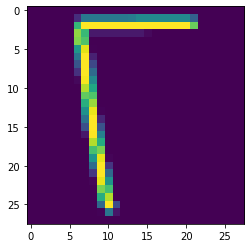

In [25]:
plt.imshow(x_test[misclassification_indices_test_set[6]])

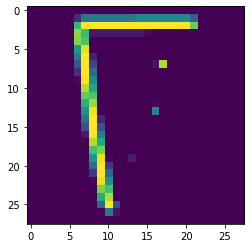

In [26]:
plt.imshow(quickdraw_vlk_cf[6])

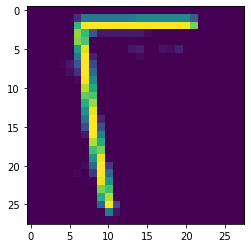

In [27]:
plt.imshow(quickdraw_cem_cf[6])

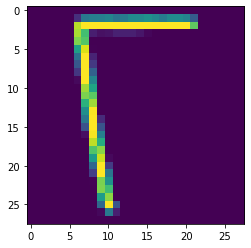

In [28]:
plt.imshow(quickdraw_min_edit_cf[6])

In [425]:
scipy.stats.sem(min_edit_l1)

0.5484794411128636

In [426]:
human_l1 = np.array(mean_l1)
human_l1_sem = scipy.stats.sem(human_l1)

human_l2 = np.array(mean_l2)
human_l2_sem = scipy.stats.sem(human_l2)


### Plots

In [434]:
materials = ['Min-Edit', 'CEM-PN', 'VLK', 'Revise*', 'Human']
x_pos = np.arange(len(materials))
CTEs = [np.mean(min_edit_l1), np.mean(cem_l1), np.mean(vlk_l1), np.mean(revise_l1), np.mean(human_l1)]
error = [min_edit_l1_sem, cem_l1_sem, vlk_l1_sem, revise_l1_sem, human_l1_sem]

#np.mean(revise_l1), revise_l1_sem

In [435]:
CTEs

[3.1801035, 9.696355, 19.456522, 90.21039, 67.991714]

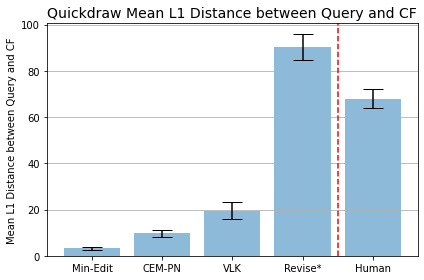

In [436]:
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Mean L1 Distance between Query and CF', fontsize=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(materials)
ax.set_title('Quickdraw Mean L1 Distance between Query and CF', fontsize = 14)
ax.yaxis.grid(True)

plt.axvline(x = 3.5, color = 'r', linestyle= '--')
# Save the figure and show
plt.tight_layout()
plt.savefig('quickdraw_bar_plot_with_error_bars_l1.pdf')
plt.show()

In [437]:
materials = ['Min-Edit', 'CEM-PN', 'VLK','Revise*', 'Human']
x_pos = np.arange(len(materials))
CTEs = [np.mean(min_edit_l2), np.mean(cem_l2), np.mean(vlk_l2), np.mean(revise_l2), np.mean(human_l2)]
error = [min_edit_l2_sem, cem_l2_sem, vlk_l2_sem, revise_l2_sem, human_l2_sem]

revise_l1_sem

5.559456812773049

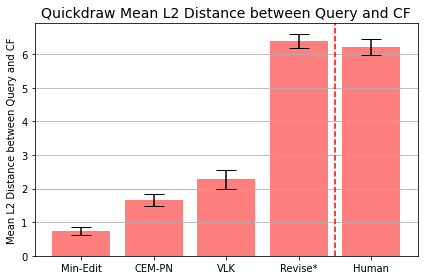

In [438]:
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10, color = 'red')
ax.set_ylabel('Mean L2 Distance between Query and CF', fontsize=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(materials)
ax.set_title('Quickdraw Mean L2 Distance between Query and CF', fontsize = 14)
ax.yaxis.grid(True)

plt.axvline(x = 3.5, color = 'r', linestyle= '--')
# Save the figure and show
plt.tight_layout()
plt.savefig('quickdraw_bar_plot_with_error_bars_l2.pdf')
plt.show()

### Quickdraw MC Dropout

Retraining the same model with MC Dropout

In [36]:
def get_dropout(input_tensor, p, mc=False):
    if mc:
        return Dropout(p)(input_tensor, training=True)
    else:
        return Dropout(p)(input_tensor)
    
    
def cnn_model(mc=False):
    
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x_in)
    x = MaxPooling2D(pool_size=2)(x)
    x = get_dropout(x, p=0.3, mc=mc)

    x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = get_dropout(x, p=0.3, mc=mc)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = get_dropout(x, p=0.5, mc=mc)
    x_out = Dense(5, activation='softmax')(x)

    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return cnn

In [37]:
cnn_mc = cnn_model(mc=True)
#cnn_mc.fit(x_train, y_train, batch_size=256, epochs=10, verbose=True)
#cnn_mc.save('cnn_quickdraw_5_classes_mc.h5', save_format='h5')
cnn_mc = load_model('cnn_quickdraw_5_classes_mc.h5')

In [38]:
true_labels_user = np.array([np.argmax(y_test[instance]) for instance in misclassification_indices_test_set])

In [39]:
import tqdm

def Monte_Carlo_Uncertainty(cf_batch):
    
    mc_predictions = []
    
    for i in tqdm.tqdm(range(100)):
        
        y_p = cnn_mc.predict(cf_batch.reshape(30,28,28,1), batch_size=1)
        mc_predictions.append(y_p)
        
        
    mean_mc = []
    
    std_mc = []
    
    for image in range(30):
        
        softmax_prediction_label = []
        
        for sample in range(100):
            
            softmax_prediction_label.append(np.array(mc_predictions[sample][image][true_labels_user[image]]))
    
    mean_mc.append(np.array(softmax_prediction_label).mean())
    std_mc.append(np.array(softmax_prediction_label).std())
    
    
    return np.mean(mean_mc), np.mean(std_mc)

In [40]:
Monte_Carlo_Uncertainty(quickdraw_min_edit_cf.reshape(30,28,28,1))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.55it/s]


(0.3409259, 0.20868967)

In [41]:
Monte_Carlo_Uncertainty(quickdraw_cem_cf.reshape(30,28,28,1))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.72it/s]


(0.18838058, 0.12946999)

In [42]:
Monte_Carlo_Uncertainty(quickdraw_vlk_cf.reshape(30,28,28,1))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 33.40it/s]


(0.3115128, 0.21424617)

In [43]:
Monte_Carlo_Uncertainty(user_0.reshape(30,28,28,1))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 33.78it/s]


(0.27403182, 0.13419741)

In [44]:
Monte_Carlo_Uncertainty(user_1.reshape(30,28,28,1))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.54it/s]


(0.6911498, 0.2096554)

In [45]:
Monte_Carlo_Uncertainty(user_2.reshape(30,28,28,1))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 33.24it/s]


(0.8113907, 0.16853845)

In [46]:
Monte_Carlo_Uncertainty(user_3.reshape(30,28,28,1))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.37it/s]


(0.8857843, 0.10999798)

In [47]:
Monte_Carlo_Uncertainty(user_4.reshape(30,28,28,1))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.20it/s]


(0.88882524, 0.13551736)

In [439]:
Monte_Carlo_Uncertainty(revise_cfes.reshape(30,28,28,1))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.11it/s]


(0.15624143, 0.034178264)

### R% Substiutability

Fitting a 1-NN Euclidean Classfier on the Generated Instances and testing on the test set. Comparing to the prototypes generated by MMD Critic. 

In [48]:
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
Counter(true_labels_user)

Counter({1: 7, 4: 4, 0: 7, 2: 5, 3: 7})

In [49]:
proto_indices = np.load('../../../../../MMD-critic/quickdraw_prototype_indices_mmd_pixel_local.npy')

In [50]:
np.where([np.argmax(y_train, axis=1) == 0])[1][4751]

23525

In [51]:
prototypes = []

for label in range(5):
    
    prototypes.append(np.where([np.argmax(y_train, axis=1) == label])[1][[instance for instance in proto_indices[label]][0:6]])

In [52]:
prototype_instances = np.array(prototypes).reshape(1,-1)[0]

In [53]:
prototypes = np.array([x_train[index] for index in prototype_instances])
prototype_labels = np.array([np.argmax(y_train[index]) for index in prototype_instances])

In [54]:
np.array(prototypes).shape

(30, 28, 28, 1)

In [55]:
np.array(prototype_labels)

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 4, 4, 4], dtype=int64)

In [56]:
true_labels_user

array([1, 4, 1, 0, 0, 2, 4, 4, 1, 0, 3, 0, 2, 3, 2, 3, 1, 4, 1, 0, 3, 1,
       3, 0, 0, 1, 2, 2, 3, 3], dtype=int64)

In [57]:
def R_sub(method_data, method_labels):
    

    image_set = method_data.reshape(30, -1)
    label_set = method_labels
    
    neigh = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
    neigh.fit(image_set, label_set)
    
    return neigh.predict(x_test.reshape(x_test.shape[0],28*28))
    
    
    

In [58]:
R_sub(quickdraw_cem_cf, true_labels_user)

array([1, 4, 0, ..., 2, 1, 1], dtype=int64)

In [59]:
prototypes

array([[[[-0.5       ],
         [-0.5       ],
         [-0.5       ],
         ...,
         [-0.5       ],
         [-0.5       ],
         [-0.5       ]],

        [[-0.5       ],
         [-0.5       ],
         [-0.5       ],
         ...,
         [-0.5       ],
         [-0.5       ],
         [-0.5       ]],

        [[-0.5       ],
         [-0.5       ],
         [-0.5       ],
         ...,
         [-0.5       ],
         [-0.5       ],
         [-0.5       ]],

        ...,

        [[-0.5       ],
         [-0.5       ],
         [-0.5       ],
         ...,
         [-0.5       ],
         [-0.5       ],
         [-0.5       ]],

        [[-0.5       ],
         [-0.5       ],
         [-0.5       ],
         ...,
         [-0.5       ],
         [-0.5       ],
         [-0.5       ]],

        [[-0.5       ],
         [-0.5       ],
         [-0.5       ],
         ...,
         [-0.5       ],
         [-0.5       ],
         [-0.5       ]]],


       [[[-0.5       ],


In [60]:
accuracy_score(np.argmax(y_test,axis=1), R_sub(prototypes, prototype_labels))

0.6920666666666667

In [61]:
accuracy_score(np.argmax(y_test,axis=1), R_sub(quickdraw_min_edit_cf, true_labels_user))

0.28573333333333334

In [62]:
accuracy_score(np.argmax(y_test,axis=1), R_sub(quickdraw_cem_cf, true_labels_user))

0.28686666666666666

In [63]:
accuracy_score(np.argmax(y_test,axis=1), R_sub(quickdraw_vlk_cf, true_labels_user))

0.31726666666666664

In [445]:
accuracy_score(np.argmax(y_test,axis=1), R_sub(revise_cfes, true_labels_user))

0.342

In [64]:
accuracy_score(np.argmax(y_test,axis=1), R_sub(user_0, true_labels_user))

0.3896

In [65]:
accuracy_score(np.argmax(y_test,axis=1), R_sub(user_1, true_labels_user))

0.3868666666666667

In [66]:
accuracy_score(np.argmax(y_test,axis=1), R_sub(user_2, true_labels_user))

0.47986666666666666

In [67]:
accuracy_score(np.argmax(y_test,axis=1), R_sub(user_3, true_labels_user))

0.2879333333333333

In [68]:
accuracy_score(np.argmax(y_test,axis=1), R_sub(user_4, true_labels_user))

0.39286666666666664

### Revise CFE's Quickdraw


In [417]:
revise_cfes = np.load('../../../../../DeDUCE-master/DeDUCE-master/REVISE_l0s-5_arr_vbatch_quickdraw.npy')

In [418]:
revise_cfes = np.array([revise_cfes[instance][true_labels_user[instance]] for instance in range(30)])

In [419]:
revise_cfes = revise_cfes.reshape(30,28,28,1)

In [420]:
np.where(np.array([revise_cfes[image].max() for image in range(30)]) >= 0)[0], len(np.where(np.array([revise_cfes[image].max() for image in range(30)]) >= 0)[0])

(array([ 0,  3,  4,  5, 10, 11, 12, 14, 15, 16, 17, 19, 21, 22, 23, 24, 26,
        28, 29], dtype=int64),
 19)

In [421]:
revise_l1 = []
revise_l2 = []

for image in [ 0,  3,  4,  5, 10, 11, 12, 14, 15, 16, 17, 19, 21, 22, 23, 24, 26,
        28, 29]:
    
    query = x_test[misclassification_indices_test_set[image]].flatten()
    revise = revise_cfes[image].flatten()
    
    
    
    revise_l1.append(scipy.spatial.distance.cityblock(query,revise))
    revise_l2.append(scipy.spatial.distance.euclidean(query,revise))
 

In [422]:
revise_l1 = np.array(revise_l1)
revise_l1_sem = scipy.stats.sem(revise_l1)

revise_l2 = np.array(revise_l2)
revise_l2_sem = scipy.stats.sem(revise_l2)

In [423]:
np.mean(revise_l1), revise_l1_sem

(90.21039, 5.559456812773049)

In [424]:
np.mean(revise_l2), revise_l2_sem

(6.387449841750295, 0.19774963042367782)

### Local Outlier Factor

Fitting a 1-NN Euclidean Classfier on the Generated Instances and testing on the test set. Comparing to the prototypes generated by MMD Critic. 

In [261]:
user_images_qd = np.array([x_test[misclassification_indices_test_set[image]].flatten() for image in range(30)])

In [262]:
user_images_qd = sklearn.preprocessing.minmax_scale(user_images_qd, feature_range = (-0.5, 0.5))

In [264]:
user_images_qd.reshape(30,28,28,1)

array([[[[-0.5],
         [-0.5],
         [-0.5],
         ...,
         [-0.5],
         [-0.5],
         [-0.5]],

        [[-0.5],
         [-0.5],
         [-0.5],
         ...,
         [-0.5],
         [-0.5],
         [-0.5]],

        [[-0.5],
         [-0.5],
         [-0.5],
         ...,
         [-0.5],
         [-0.5],
         [-0.5]],

        ...,

        [[-0.5],
         [-0.5],
         [-0.5],
         ...,
         [-0.5],
         [-0.5],
         [-0.5]],

        [[-0.5],
         [-0.5],
         [-0.5],
         ...,
         [-0.5],
         [-0.5],
         [-0.5]],

        [[-0.5],
         [-0.5],
         [-0.5],
         ...,
         [-0.5],
         [-0.5],
         [-0.5]]],


       [[[-0.5],
         [-0.5],
         [-0.5],
         ...,
         [-0.5],
         [-0.5],
         [-0.5]],

        [[-0.5],
         [-0.5],
         [-0.5],
         ...,
         [-0.5],
         [-0.5],
         [-0.5]],

        [[-0.5],
         [-0.5],
      

In [273]:
user_labels_qd = np.array([y_test[misclassification_indices_test_set[image]].flatten() for image in range(30)])

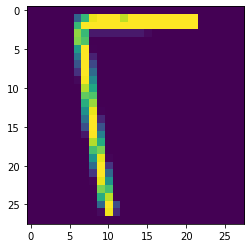

In [274]:
plt.imshow(user_images_qd[6].reshape(28,28))

In [275]:
user_images_qd

array([[-0.5, -0.5, -0.5, ..., -0.5, -0.5, -0.5],
       [-0.5, -0.5, -0.5, ..., -0.5, -0.5, -0.5],
       [-0.5, -0.5, -0.5, ..., -0.5, -0.5, -0.5],
       ...,
       [-0.5, -0.5, -0.5, ..., -0.5, -0.5, -0.5],
       [-0.5, -0.5, -0.5, ..., -0.5, -0.5, -0.5],
       [-0.5, -0.5, -0.5, ..., -0.5, -0.5, -0.5]], dtype=float32)

In [286]:
y_quickdraw = np.argmax(user_labels_qd, axis=1)

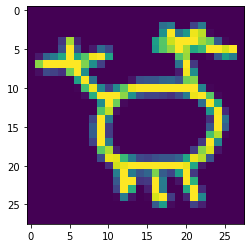

In [400]:
plt.imshow(user_images_qd[15].reshape(28,28))

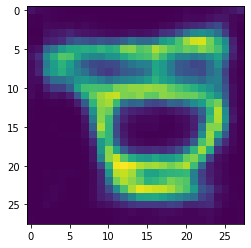

In [443]:
plt.imshow(revise_cfes[15])

In [444]:
np.save('revise_cfes_qd.npy', revise_cfes)

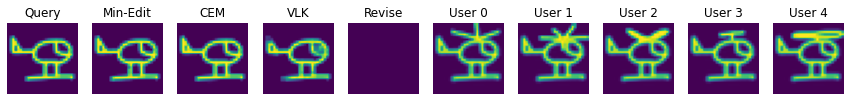

In [442]:
for image in [13]:

    image_index = image

    f, axarr = plt.subplots(nrows=1,ncols=10, figsize=(15,15))
    plt.sca(axarr[0]); 
    plt.imshow(x_test[misclassification_indices_test_set[image_index]], cmap='viridis'); plt.title('Query')
    plt.axis('off')

    
    plt.sca(axarr[1]); 
    plt.imshow(quickdraw_min_edit_cf[image_index],cmap='viridis'); plt.title('Min-Edit')
    plt.axis('off')

    plt.sca(axarr[2]); 
    plt.imshow(quickdraw_cem_cf[image_index],cmap='viridis'); plt.title('CEM')
    plt.axis('off')
    
    plt.sca(axarr[3]); 
    plt.imshow(quickdraw_vlk_cf[image_index],cmap='viridis'); plt.title('VLK')
    plt.axis('off')
    
    
    plt.sca(axarr[4]); 
    plt.imshow(revise_cfes[image_index],cmap='viridis'); plt.title('Revise')
    plt.axis('off')
    
    
    plt.sca(axarr[5]); 
    plt.imshow(user_0[image_index], cmap='viridis'); plt.title('User 0')
    plt.axis('off')

    plt.sca(axarr[6]); 
    plt.imshow(user_1[image_index], cmap='viridis'); plt.title('User 1');
    plt.axis('off')

    plt.sca(axarr[7]); 
    plt.imshow(user_2[image_index], cmap='viridis'); plt.title('User 2');
    plt.axis('off')


    plt.sca(axarr[8]); 
    plt.imshow(user_3[image_index], cmap='viridis'); plt.title('User 3');
    plt.axis('off')

    plt.sca(axarr[9]); 
    plt.imshow(user_4[image_index], cmap='viridis'); plt.title('User 4');
    plt.axis('off')


    plt.show()

In [447]:
np.load('user_explanations_quickdraw.npy').shape

(5, 30, 28, 28, 1)

In [462]:
np.save('quickdraw_misclassified_image_user_set.npy', np.array([x_test[misclassification_indices_test_set[image_index]] for image_index in range(30)]))

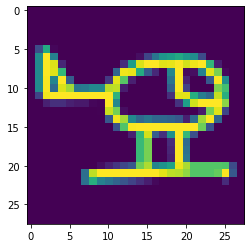

In [464]:
plt.imshow(np.load('quickdraw_misclassified_image_user_set.npy')[13])

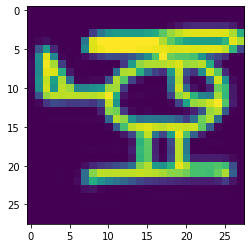

In [486]:
plt.imshow(user_4[13])

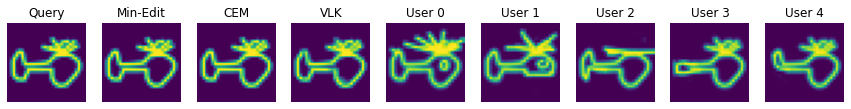

In [481]:
for image in [10]:

    image_index = image

    f, axarr = plt.subplots(nrows=1,ncols=9, figsize=(15,15))
    plt.sca(axarr[0]); 
    plt.imshow(x_test[misclassification_indices_test_set[image_index]], cmap='viridis'); plt.title('Query')
    plt.axis('off')

    
    plt.sca(axarr[1]); 
    plt.imshow(quickdraw_min_edit_cf[image_index],cmap='viridis'); plt.title('Min-Edit')
    plt.axis('off')

    plt.sca(axarr[2]); 
    plt.imshow(quickdraw_cem_cf[image_index],cmap='viridis'); plt.title('CEM')
    plt.axis('off')
    
    plt.sca(axarr[3]); 
    plt.imshow(quickdraw_vlk_cf[image_index],cmap='viridis'); plt.title('VLK')
    plt.axis('off')
    
    plt.sca(axarr[4]); 
    plt.imshow(user_0[image_index], cmap='viridis'); plt.title('User 0')
    plt.axis('off')

    plt.sca(axarr[5]); 
    plt.imshow(user_1[image_index], cmap='viridis'); plt.title('User 1');
    plt.axis('off')

    plt.sca(axarr[6]); 
    plt.imshow(user_2[image_index], cmap='viridis'); plt.title('User 2');
    plt.axis('off')


    plt.sca(axarr[7]); 
    plt.imshow(user_3[image_index], cmap='viridis'); plt.title('User 3');
    plt.axis('off')

    plt.sca(axarr[8]); 
    plt.imshow(user_4[image_index], cmap='viridis'); plt.title('User 4');
    plt.axis('off')


    plt.show()